### Introduction to CNN
we will focus on following in this notebook
**Convolutional Neural Networks (CNNs)**  
   - Introduction to CNNs, their building blocks (convolution, max-pooling).  
   - A small CNN example to visualize **feature maps** and understand how CNNs learn.  


In [12]:
# Import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [13]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from torchvision.utils import make_grid
import os


In [14]:
#@title 🧠 Build a small neural network using PyTorch

#Model Definition
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)  # In channels = 1; Out-channels = 4; Default: Stride = 1; Padding = 0
        self.pool1 = nn.MaxPool2d(2)                 # Max Pooling Layer 2x2 Default: Stride = 1;
        self.conv2 = nn.Conv2d(4, 4, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4 * 30 * 30, 128)       #Fully Connected Layer
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)         # [1,4,126,126]
        x = self.pool1(x)         # [1,4,63,63]
        x = self.conv2(x)         # [1,4,61,61]
        x = self.pool2(x)         # [1,4,30,30]

        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))   #[1,128]      #Relu Activation
        x = self.fc2(x)           #[1,2]

        return x


In [15]:
import gdown
#@title Download an Image
# Shared Google Drive link
url = "https://drive.google.com/uc?id=1EhUvzO_2AXxFETO_CQXq-gh-vaJo49yS"

# Output filename
output = "demo_image.jpg"

# Download silently
gdown.download(url, output, quiet=True)

'demo_image.jpg'

In [16]:
#@title 📤 Load Single Image
from monai.transforms import LoadImage

# image_path = "./download.png"  # Update with your image path
image_path = "./demo_image.jpg"  # Update with your image path
load_image = LoadImage(image_only=True)  # Set image_only=True to load the image as an array
image = load_image(image_path)  # Read the image

In [17]:
#@title 🧹 Prepare our data
def load_and_preprocess_image(path):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0], [1])  # [0,1] scaling
    ])
    img = Image.open(path).convert("L")
    return transform(img).unsqueeze(0)

In [18]:
input_tensor = load_and_preprocess_image(image_path)
print(input_tensor.shape)

torch.Size([1, 1, 128, 128])


In [19]:
#@title 📊  Visualize Feature Maps
# ---- 3. Model Definition ----
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)           # → [4,126,126]
        self.pool1 = nn.MaxPool2d(2)                          # → [4,63,63]
        self.conv2 = nn.Conv2d(4, 4, kernel_size=3)           # → [4,61,61]
        self.pool2 = nn.MaxPool2d(2)                          # → [4,30,30]
        self.fc1 = nn.Linear(4 * 30 * 30, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        feature_maps = []

        # Input
        feature_maps.append(("Input", x.clone(), x.shape))

        # Conv1
        x_in = x.clone()
        x = self.conv1(x)
        feature_maps.append(("Conv1: 3x3 Kernel with inchannel 1 and outchannel 4 \n (126 = 128-3+1)", x.clone(), x_in.shape, x.shape))

        # Pool1
        x_in = x.clone()
        x = self.pool1(x)
        feature_maps.append(("MaxPool1: 2x2 \n (63 = 126/2)", x.clone(), x_in.shape, x.shape))

        # Conv2
        x_in = x.clone()
        x = self.conv2(x)
        feature_maps.append(("Conv2: 3x3 Kernel with inchannel 4 and outchannel 4 \n (61 = 63-3+1)", x.clone(), x_in.shape, x.shape))

        # Pool2
        x_in = x.clone()
        x = self.pool2(x)
        feature_maps.append(("MaxPool2: 2x2 \n (30 ~ 61/2)", x.clone(), x_in.shape, x.shape))

        # FC1
        x_fc_in = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x_fc_in))
        feature_maps.append(("FC1 \n ( 3600 = 4*30*30 )", None, x_fc_in.shape, x.shape))

        # FC2
        x_fc_in = x.clone()
        x = self.fc2(x_fc_in)
        feature_maps.append(("FC2", None, x_fc_in.shape, x.shape))

        return x, feature_maps

# ---- 4. Visualization ----
def show_feature_maps_scaled(feature_maps):
    for entry in feature_maps:
        name = entry[0]

        if name == "Input":
            fmap = entry[1]
            shape = entry[2]
            print(f"📥 {name} Shape: {list(shape)}")
            fmap = fmap[0]  # remove batch
            channels = fmap.shape[0]
            fig, axes = plt.subplots(1, channels, figsize=(channels * 2, 2))
            for c in range(channels):
                ax = axes[c] if channels > 1 else axes
                ax.imshow(fmap[c].detach().cpu(), cmap='gray')
                ax.axis('off')
            plt.tight_layout()
            plt.show()

        elif entry[1] is not None:  # Conv/Pool layers
            fmap, input_shape, output_shape = entry[1], entry[2], entry[3]
            print(f" {name}")
            print(f"       Input Shape : {list(input_shape)}")
            print(f"       Output Shape: {list(output_shape)}")

            fmap = fmap[0]  # remove batch
            channels = fmap.shape[0]
            fig, axes = plt.subplots(1, channels, figsize=(channels * 2, 2))
            for c in range(channels):
                ax = axes[c] if channels > 1 else axes
                ax.imshow(fmap[c].detach().cpu(), cmap='gray')
                ax.axis('off')
            plt.tight_layout()
            plt.show()

        else:  # FC layers
            _, _, input_shape, output_shape = entry
            print(f" {name}")
            print(f"      Input Shape : {list(input_shape)}")
            print(f"      Output Shape: {list(output_shape)}")


In [20]:
# ---- 5. Run Everything ----
model = CustomCNN()
print(model)


CustomCNN(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


📥 Input Shape: [1, 1, 128, 128]


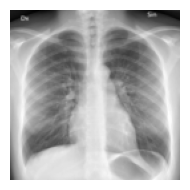

 Conv1: 3x3 Kernel with inchannel 1 and outchannel 4 
 (126 = 128-3+1)
       Input Shape : [1, 1, 128, 128]
       Output Shape: [1, 4, 126, 126]


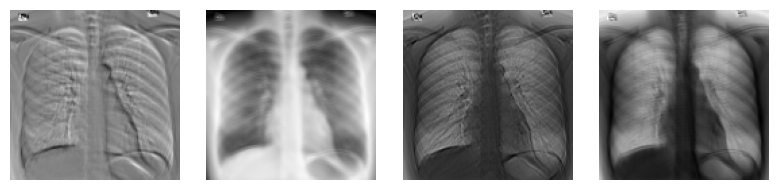

 MaxPool1: 2x2 
 (63 = 126/2)
       Input Shape : [1, 4, 126, 126]
       Output Shape: [1, 4, 63, 63]


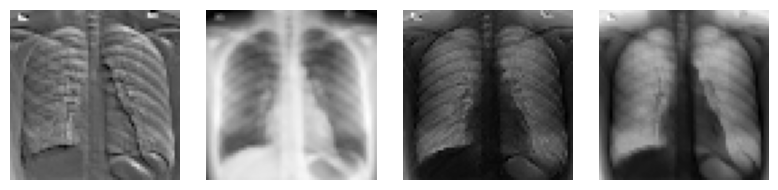

 Conv2: 3x3 Kernel with inchannel 4 and outchannel 4 
 (61 = 63-3+1)
       Input Shape : [1, 4, 63, 63]
       Output Shape: [1, 4, 61, 61]


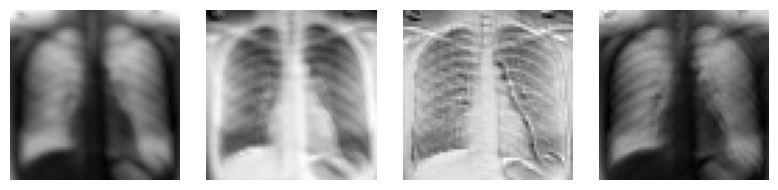

 MaxPool2: 2x2 
 (30 ~ 61/2)
       Input Shape : [1, 4, 61, 61]
       Output Shape: [1, 4, 30, 30]


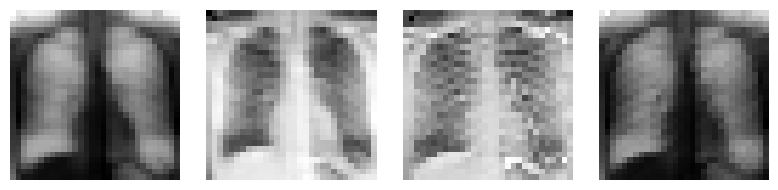

 FC1 
 ( 3600 = 4*30*30 )
      Input Shape : [1, 3600]
      Output Shape: [1, 128]
 FC2
      Input Shape : [1, 128]
      Output Shape: [1, 2]


In [21]:
model.eval()

input_tensor = load_and_preprocess_image(image_path)
with torch.no_grad():
    logits, fmap_list = model(input_tensor)

# ---- 6. Visualize ----
show_feature_maps_scaled(fmap_list)

In [22]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

NameError: name 'optim' is not defined